## Global Black Box Optimization with RNNS

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

1.1.0


In [2]:
def poly(a,b,c,x):
    return a*(x-b)**2+c

def min_poly(a,b,c):
    return b, c

In [3]:
def gen_data(n_train, n_test):
    a_train = np.random.uniform(size=(n_train,1),low = 0.5, high = 5.0)
    b_train = np.random.uniform(size=(n_train,1),low = -3.0, high = 3.0)
    c_train = np.random.uniform(size=(n_train,1),low = -2.0, high = 2.0)
    
    a_test = np.random.uniform(size=(n_test,1),low = 0.5, high = 5.0)
    b_test = np.random.uniform(size=(n_test,1),low = -3.0, high = 3.0)
    c_test = np.random.uniform(size=(n_test,1),low = -2.0, high = 2.0)
    
    return (a_train, b_train, c_train, a_test, b_test, c_test)

In [4]:
# Number of Traing/Test examples
batch_size = n_train = 3
n_test = 1

# Number of hidden states in RNN cell
n_hidden = 20

# Sequence length
num_steps = 5 

# Generate Training Data
a_train, b_train, c_train, a_test, b_test, c_test = gen_data(n_train, n_test)

In [5]:
# Create RNN Cell
# x, h = RNN(x, y, h)

with tf.variable_scope('rnn_cell', reuse=None):
    W = tf.get_variable('W', [1 + 1 + n_hidden, 1 + n_hidden],\
                       initializer=tf.truncated_normal_initializer(stddev=0.01))
    b = tf.get_variable('b', [1 + n_hidden], initializer=tf.constant_initializer(0.0))

def rnn_cell(x, y, h):
    with tf.variable_scope('rnn_cell', reuse=True):
        W = tf.get_variable('W', [1 + 1 + n_hidden, 1 + n_hidden],\
                       initializer=tf.truncated_normal_initializer(stddev=0.01))
        b = tf.get_variable('b', [1 + n_hidden], initializer=tf.constant_initializer(0.0))
        z = tf.nn.tanh(tf.matmul(tf.concat([x, y, h], 1), W) + b)
        
        return tf.split(z,[1, n_hidden],axis=1)

In [6]:
# Create Model
a = tf.placeholder(tf.float32, [batch_size, 1])
b = tf.placeholder(tf.float32, [batch_size, 1])
c = tf.placeholder(tf.float32, [batch_size, 1])

x_0 = tf.zeros([batch_size, 1])
h_0 = tf.truncated_normal([batch_size, n_hidden],stddev=0.1)

h = h_0
x = x_0
sample_points = [x]
f_sum = 0
for i in range(num_steps):
    y = poly(a,b,c,x)
    x, h = rnn_cell(x, y, h)
    sample_points.append(x)
    f_sum += tf.reduce_mean(y)/num_steps


In [7]:
train_step = tf.train.AdamOptimizer(0.01).minimize(f_sum)
#train_step = tf.train.GradientDescentOptimizer(1.0).minimize(f_out)

[<tf.Tensor 'gradients/rnn_cell_4/split_grad/concat:0' shape=(3, 21) dtype=float32>, None, None]
[<tf.Tensor 'gradients/rnn_cell_3/split_grad/concat:0' shape=(3, 21) dtype=float32>, None, None]
[<tf.Tensor 'gradients/rnn_cell_2/split_grad/concat:0' shape=(3, 21) dtype=float32>, None, None]
[<tf.Tensor 'gradients/rnn_cell_1/split_grad/concat:0' shape=(3, 21) dtype=float32>, None, None]


In [8]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [14]:
# Train the Network
epochs = 1000
for ep in range(epochs):
    sess.run([train_step], feed_dict={a: a_train, b: b_train, c: c_train})
    
    if ep % 100 == 0:
        loss = sess.run([f_sum], feed_dict={a: a_train, b: b_train, c: c_train})
        print(loss)
    
# Extract Samples
samples = sess.run([sample_points], feed_dict={a: a_train, b: b_train, c: c_train})
samples = np.array(samples[0]).reshape(num_steps+1,n_train).T

[7.5757341]
[7.586977]
[7.5787711]
[7.5797567]
[7.5775299]
[7.5762429]
[7.5728121]
[7.6865749]
[7.6473765]
[7.5720754]


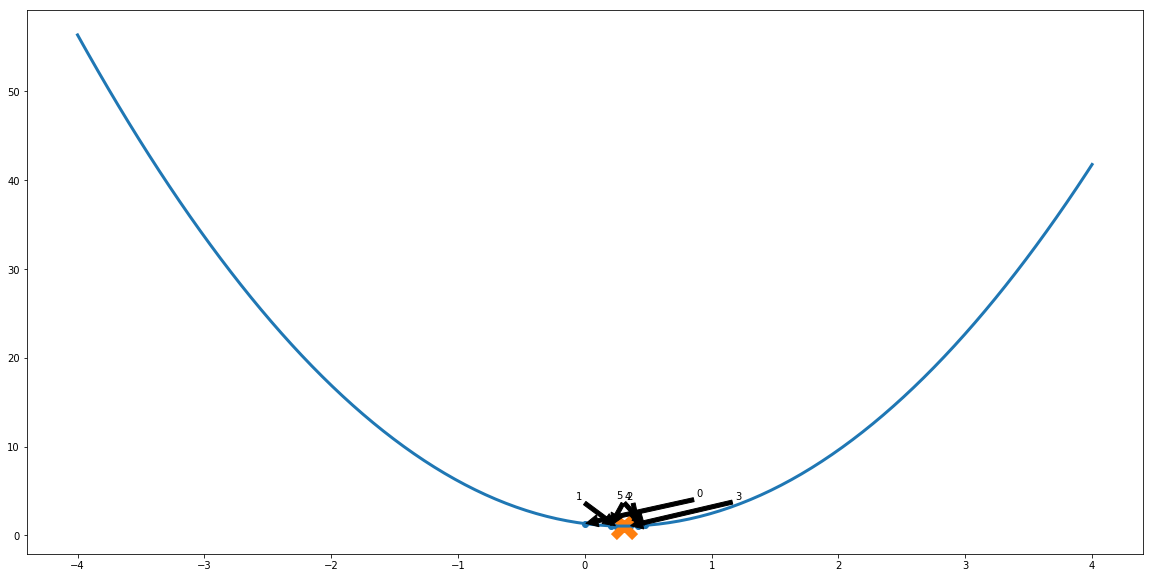

[ 0.          0.24287038  0.41840249  0.35304141  0.20327398  0.4722476 ]
[ 0.30555377]


In [15]:
def plot_result(i): 
    annotation = list(range(num_steps+1))
    xx = np.linspace(-4,4,200)
    yy = poly(a_train[i],b_train[i],c_train[i],xx)

    samples_x = samples[i]
    samples_y = poly(a_train[i],b_train[i],c_train[i],samples_x)
    
    x_min, y_min = min_poly(a_train[i],b_train[i],c_train[i])

    fig, ax = plt.subplots(figsize=(20,10))
    ax.plot(xx,yy,linewidth=3)
    ax.scatter(samples_x,samples_y)
    ax.scatter(x_min, y_min, marker='x', linewidth = 30)
    for i, txt in enumerate(annotation):
        ax.annotate(str(txt), (samples_x[i],samples_y[i]),\
                    xytext=(samples_x[i]+np.random.uniform(-1,1),\
                            samples_y[i]+3.0), arrowprops=dict(facecolor='black', shrink=0.01))
    plt.show()
    print(samples_x)
    print(x_min)

plot_result(0)

In [ ]:
plot_result(1)

In [ ]:
plot_result(2)